
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

# Load Metrics
from my_example.metrics.MazeMetrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _enhanced_effect_error

# Load Plotting Wrappers
from my_example.metrics.MazePlottingWrapper import \
    parse_metrics_to_df, \
    plot_performance

# Load environments
import gym
import my_mazes

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8
SLIPPERY_PROB = 0.
MAZE = "MazeE2-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
EPSILON = 0.8
BETA_ALP = 0.05

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#RL Set Up
GAMMA = 0.95
BETA_RL = 0.05

#GA Set Up
CROSSOVER = 0.8
MUTATION = 0.3

#BEACS Set Up
DO_ZIP = True
ENABLE_PEP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 2

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ □ $ □ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ A ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of BEACS - Exploration

In [4]:
%%time
#%%prun -l 0.5 -T profiling.txt

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    mu=MUTATION,
    chi=CROSSOVER,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

/Users/romain/miniconda3/envs/alcs/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


CPU times: user 6min 55s, sys: 4.44 s, total: 7min
Wall time: 8min 11s


### Performance

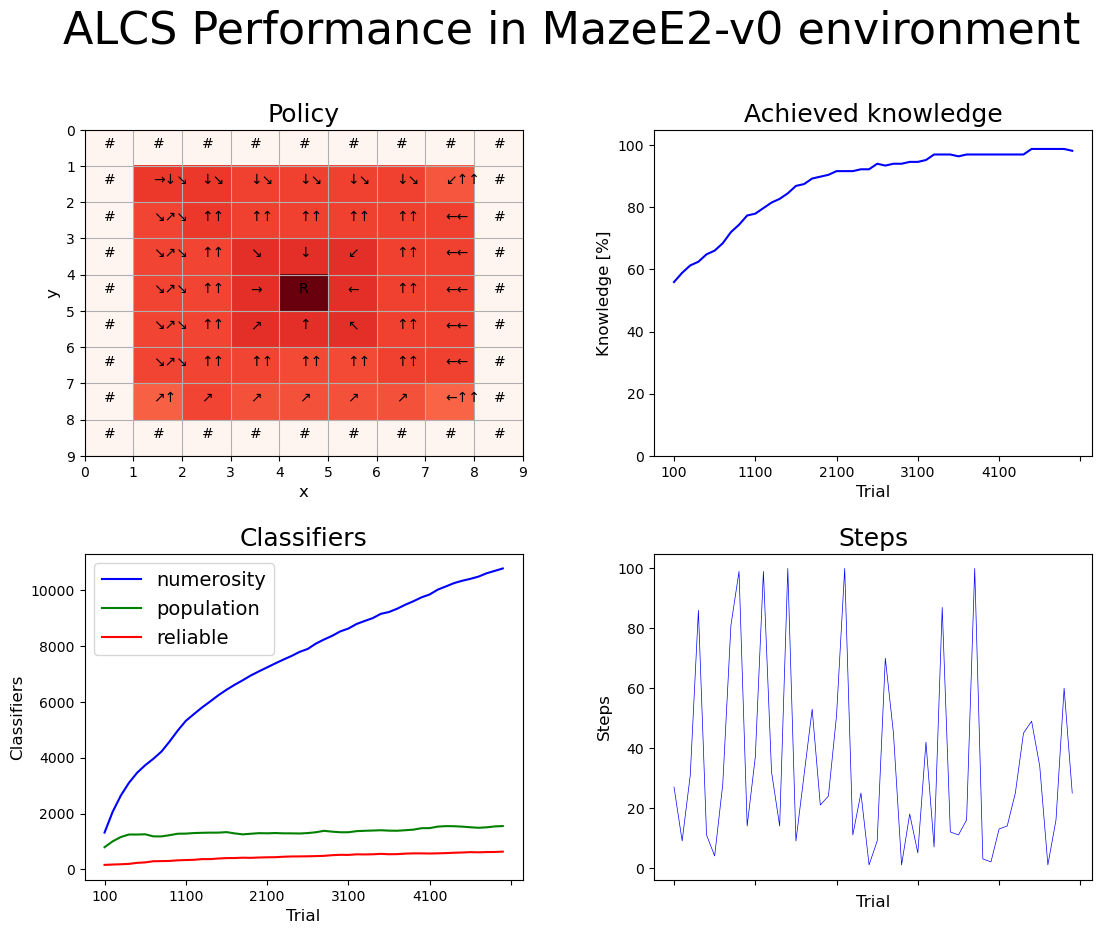

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)
print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%\n")

if DO_ZIP:
    duplicate_population = agent_explore.duplicate_population()
    agent_explore.zip_population()
    population_explore = agent_explore.get_population()

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%")

Full knowledge was achieved at trials  -1 , was stable at  -1  and the last time it was achieved at  -1
There are  5  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 98.21428571428571, 'population': 1552, 'numerosity': 10781, 'reliable': 635}
Mean reliable population specifity is  (0.6625984251968504, 0.4363532110091743, 0.7808752997601919)
Accumulated Error on PEP Probabilities : 1.2186635259478795 %

There are  5  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 98.21428571428571, 'population': 772, 'numerosity': 7752, 'reliable': 424}
Mean reliable population specifity is  (0.6108490566037735, 0.3675, 0.7440693430656934)
Accumulated Error on PEP Probabilities : 1.2186635259478795 %


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

C:###9#### A:3 None E:(###0####:1)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 4.268e-06
exp: 781   num: 20 ee: False
Mark: empty Can_be_generalized: [True, True, True, True, True, True, True, True] Aliased_state:  PAI_state: 
tga: 164159 tbseq: 981   talp: 164159 tav: 231.3  



C:####9### A:4 None E:(####0###:1)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.001806
exp: 564   num: 20 ee: False
Mark: empty Can_be_generalized: [True, True, True, True, True, True, True, True] Aliased_state:  PAI_state: 
tga: 164239 tbseq: 1707  talp: 164239 tav: 221.0  



C:#####9## A:5 None E:(#####0##:1)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.05953
exp: 414   num: 20 ee: False
Mark: empty Can_be_generalized: [True, True, True, True, True, True, True, True] Aliased_state:  PAI_state: 
tga: 164080 tbseq: 244   talp: 164080 tav: 406.6  



C:##9##### A:2 None E:(##0#####:1)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.03534
exp: 431   num: 1

In [8]:
agent_explore.get_pai_states_memory()

[('0', '0', '0', '0', '0', '0', '0', '0'),
 ('0', '1', '1', '1', '0', '0', '0', '0'),
 ('0', '0', '0', '0', '0', '1', '1', '1'),
 ('1', '1', '0', '0', '0', '0', '0', '1'),
 ('0', '0', '0', '1', '1', '1', '0', '0')]

## Training of BEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=GAMMA,
    epsilon=0.2
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 17.2 s, sys: 145 ms, total: 17.4 s
Wall time: 19.6 s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=GAMMA,
    epsilon=0.0
)

agent_exploit_rl_start = BEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 18.2 s, sys: 231 ms, total: 18.4 s
Wall time: 24.2 s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    epsilon=0.0,
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 16.2 s, sys: 138 ms, total: 16.3 s
Wall time: 18.6 s


### Performance

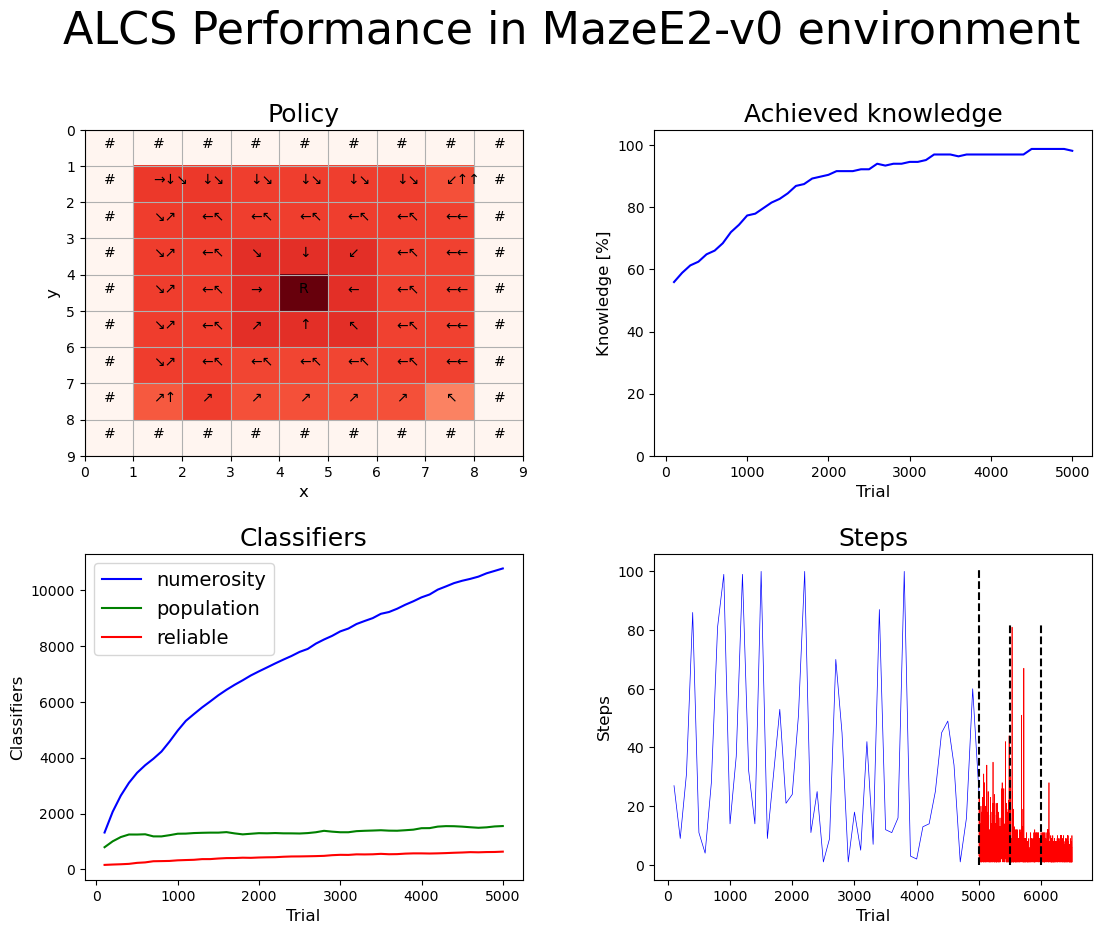

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  34.16  for a total of  5000  trials in EXPLORATION
Average number of steps to solve the maze is  7.066  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  4.884  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  4.414  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 98.21428571428571, 'population': 772, 'numerosity': 7752, 'reliable': 424}
{'knowledge': 98.21428571428571, 'population': 772, 'numerosity': 7752, 'reliable': 424}
{'knowledge': 98.21428571428571, 'population': 772, 'numerosity': 7752, 'reliable': 424}
{'knowledge': 98.21428571428571, 'population': 772, 'numerosity': 7752, 'reliable': 424}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl if cl.is_reliable()]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

424


C:###9#### A:3 None E:(###0####:1)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 1.356e-08
exp: 781   num: 20 ee: False
Mark: empty Can_be_generalized: [True, True, True, True, True, True, True, True] Aliased_state:  PAI_state: 
tga: 164159 tbseq: 981   talp: 164159 tav: 231.3  



C:#####9## A:5 None E:(#####0##:1)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 4.097e-06
exp: 414   num: 20 ee: False
Mark: empty Can_be_generalized: [True, True, True, True, True, True, True, True] Aliased_state:  PAI_state: 
tga: 164080 tbseq: 244   talp: 164080 tav: 406.6  



C:####9### A:4 None E:(####0###:1)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 3.955e-05
exp: 564   num: 20 ee: False
Mark: empty Can_be_generalized: [True, True, True, True, True, True, True, True] Aliased_state:  PAI_state: 
tga: 164239 tbseq: 1707  talp: 164239 tav: 221.0  



C:#9###### A:1 None E:(#0######:1)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.001769
exp: 38

C:00000000 A:6 [5] E:(#####111:89, ###11111:15, ###9####:9, ###111##:18, ########:28, ####9###:5, 9#######:4)
q: 1.0    ra: 853.2  rb: 791.9  ir: 243.1  f: 822.6  err: 135.5 
exp: 154   num: 20 ee: False
Mark: empty Can_be_generalized: [False, True, True, False, False, False, False, False] Aliased_state: 00000000 PAI_state: 00000000
tga: 164252 tbseq: 6258  talp: 164252 tav: 1.791e+03 



C:00000111 A:1 [1, 3] E:(#####000:69, 9####000:13, ####9000:19)
q: 1.0    ra: 822.5  rb: 860.4  ir: 193.7  f: 822.5  err: 123.4 
exp: 93    num: 20 ee: False
Mark: empty Can_be_generalized: [False, True, True, True, False, True, True, True] Aliased_state: 00000111 PAI_state: 11000001
tga: 162828 tbseq: 35324 talp: 162828 tav: 2.376e+03 



C:##09#### A:4 None E:(##90####:1)
q: 0.9948 ra: 826.6  rb: 778.1  ir: 0.0    f: 822.3  err: 251.7 
exp: 89    num: 19 ee: False
Mark: empty Can_be_generalized: [True, True, True, True, True, True, True, True] Aliased_state:  PAI_state: 
tga: 162782 tbseq: 625   tal